<a href="https://colab.research.google.com/github/CharlesPoletowin/YCBS-273/blob/master/Lecture2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

Disclaimer: This notebook is modified from the following notebooks:
- https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/nn_tutorial.ipynb#scrollTo=N29T2vcqOnVU

# End-to-end ML pipeline example

## Data setup

We will generate our own data. In particular, we will sample points on a polynomial curve. We will add random noise to the data points in ordeer to make the data realistic.

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import math

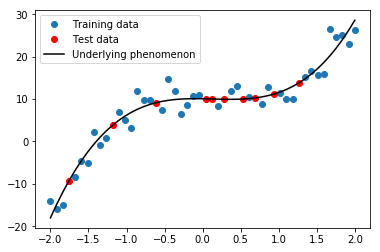

In [0]:
def f(x):
  return (x - 0.2)*(x + 0.3)*(3*x - 1.5) + 10

SIZE = 50
x = np.linspace(-2, 2, SIZE, np.float32)
y = f(x)

# add noise
y_noise = y + 2 * np.random.randn(SIZE)

# data split into training and testing data
idx = list(range(SIZE))
np.random.shuffle(idx)

x_train = x[idx][:40]
y_train = y_noise[idx][:40]

x_test = x[idx][40:]
y_test = y[idx][40:]

# plot train and test points
plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test, 'ro')
plt.plot(x, y, 'k-')
plt.legend(['Training data', 'Test data', 'Underlying phenomenon'])

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [0]:
x_train, y_train, x_test, y_test = map(
    torch.FloatTensor, (x_train[:, np.newaxis], y_train[:, np.newaxis], x_test[:, np.newaxis], y_test[:, np.newaxis])
)
n, _ = x_train.shape

## Loss function

In [0]:
def mse(inp, target):
  return torch.mean((inp - target)**2)
  
loss_func = mse

### Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating neural
nets, such as pooling functions. (There are also functions for doing convolutions,
linear layers, etc, but as we'll see, these are usually better handled using
other parts of the library.)

In [0]:
import torch.nn.functional as F

loss_func = F.mse_loss

## Model definition

In [0]:
class Mnist_mlp_classifier():
  def __init__(self):
    self.weights_1 = torch.randn(1, 800)
    self.weights_1.requires_grad_()
    self.bias_1 = torch.zeros(1, requires_grad=True)

    self.weights_2 = torch.randn(800, 1)
    self.weights_2.requires_grad_()
    self.bias_2 = torch.zeros(1, requires_grad=True)
  
  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.tanh(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    out = h
    return out

### Refactor using nn.Module
Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.

In [0]:
from torch import nn

class Mnist_mlp_classifier(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights_1 = nn.Parameter(torch.randn(1, 800) / math.sqrt(1))
      self.bias_1 = nn.Parameter(torch.zeros(800))
      
      self.weights_2 = nn.Parameter(torch.randn(800, 1) / math.sqrt(784))
      self.bias_2 = nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.tanh(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    out = h
    return out

In [0]:
model = Mnist_mlp_classifier()
print('===========\nParameters shape\n===========')
for p in model.parameters():
  print(p.shape)

Parameters shape
torch.Size([1, 800])
torch.Size([800])
torch.Size([800, 1])
torch.Size([1])


### Refactor using nn.Linear

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.

In [0]:
class Mnist_mlp_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1, 800)
    self.layer2 = nn.Linear(800, 1)

  def forward(self, xb):
    h =  self.layer1(xb)
    h = F.tanh(h)
    h =  self.layer2(h)
    out = h
    return out

In [0]:
model = Mnist_mlp_classifier()
print('===========\nParameters shape\n===========')
for p in model.parameters():
  print(p.shape)

Parameters shape
torch.Size([800, 1])
torch.Size([800])
torch.Size([1, 800])
torch.Size([1])


## Training

In [0]:
lr = 0.001  # learning rate
epochs = 250  # how many epochs to train for
bs = 10  # batch size

model = Mnist_mlp_classifier()

y_pred = model.forward(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    with torch.no_grad():
      for p in model.parameters():
        p -= p.grad * lr
      model.zero_grad()
      
  print('Loss at epoch %d : %f' % (epoch, loss))

y_pred = model(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

### Refactor using Dataset and DataLoader

The Dataset and DataLoader classes provide us with a convinient way of batching and iterating through out datasets.

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

lr = 0.001  # learning rate
epochs = 250  # how many epochs to train for
bs = 10  # batch size

train_dataset = TensorDataset(x_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=bs)

model = Mnist_mlp_classifier()

y_pred = model.forward(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

for epoch in range(epochs):
  for xb, yb in train_data_loader:
    
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    with torch.no_grad():
      for p in model.parameters():
        p -= p.grad * lr
      model.zero_grad()
      
  print('Loss at epoch %d : %f' % (epoch, loss))

y_pred = model(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

### Refactor using optim
------------------------------

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

and instead use just:
::
  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)



In [0]:
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

lr = 0.001  # learning rate
epochs = 250  # how many epochs to train for
bs = 10  # batch size

train_dataset = TensorDataset(x_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=bs)

model = Mnist_mlp_classifier()
optimizer = optim.SGD(model.parameters(), lr=lr)

y_pred = model.forward(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

for epoch in range(epochs):
  for xb, yb in train_data_loader:
    
    pred = model.forward(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
      
  print('Loss at epoch %d : %f' % (epoch, loss))

y_pred = model.forward(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

## Visualizing the trained model 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


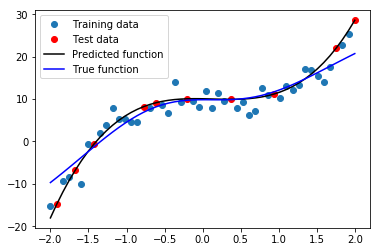

In [0]:
x = torch.linspace(-2, 2, 50).unsqueeze(1)
y_ = model.forward(x)
y = f(x)
plt.plot(x_train.numpy(), y_train.detach().numpy(), 'o')
plt.plot(x_test.numpy(), y_test.detach().numpy(), 'ro')
plt.plot(x.numpy(), y.detach().numpy(), 'k-')
plt.plot(x.numpy(), y_.detach().numpy(), 'b-')
plt.legend(['Training data', 'Test data', 'Predicted function', 'True function'])

# Whole code in one place

In [0]:
from matplotlib import pyplot as plt
import math
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# params
lr = 0.001  # learning rate
epochs = 250  # how many epochs to train for
bs = 10  # batch size

# data processing
def f(x):
  return (x - 0.2)*(x + 0.3)*(3*x - 1.5) + 10

SIZE = 50
x = np.linspace(-2, 2, SIZE, np.float32)
y = f(x)

y_noise = y + 2 * np.random.randn(SIZE)

idx = list(range(SIZE))
np.random.shuffle(idx)

x_train, y_train, x_test, y_test = x[idx][:40], y_noise[idx][:40], x[idx][40:], y_noise[idx][40:]

x_train, y_train, x_test, y_test = map(
    torch.FloatTensor, (x_train[:, np.newaxis], y_train[:, np.newaxis], x_test[:, np.newaxis], y_test[:, np.newaxis])
)
n, _ = x_train.shape

train_dataset = TensorDataset(x_train, y_train)
train_data_loader = DataLoader(train_dataset, batch_size=bs)

# model definition
class mlp_regreessor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1, 800)
    self.layer2 = nn.Linear(800, 1)

  def forward(self, xb):
    h =  self.layer1(xb)
    h = F.relu(h)
    h =  self.layer2(h)
    out = h
    return out
  
model = mlp_regreessor()

# loss function
loss_func = F.mse_loss

# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# training loop
for epoch in range(epochs):
  for xb, yb in train_data_loader:
    
    pred = model.forward(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
      
  print('Loss at epoch %d : %f' % (epoch, loss))

# model evaluation
y_pred = model.forward(x_test)
print('Test error of model after training: ', loss_func(y_pred, y_test))

Loss at epoch 0 : 29.780958
Loss at epoch 1 : 19.800341
Loss at epoch 2 : 18.759584
Loss at epoch 3 : 17.916088
Loss at epoch 4 : 16.934116
Loss at epoch 5 : 15.963359
Loss at epoch 6 : 15.069337
Loss at epoch 7 : 14.266337
Loss at epoch 8 : 13.550096
Loss at epoch 9 : 12.911761
Loss at epoch 10 : 12.342286
Loss at epoch 11 : 11.832714
Loss at epoch 12 : 11.375507
Loss at epoch 13 : 10.964307
Loss at epoch 14 : 10.593369
Loss at epoch 15 : 10.257432
Loss at epoch 16 : 9.952083
Loss at epoch 17 : 9.673658
Loss at epoch 18 : 9.418772
Loss at epoch 19 : 9.184479
Loss at epoch 20 : 8.968196
Loss at epoch 21 : 8.768126
Loss at epoch 22 : 8.582006
Loss at epoch 23 : 8.408387
Loss at epoch 24 : 8.245583
Loss at epoch 25 : 8.092406
Loss at epoch 26 : 7.947877
Loss at epoch 27 : 7.811456
Loss at epoch 28 : 7.681782
Loss at epoch 29 : 7.558469
Loss at epoch 30 : 7.440487
Loss at epoch 31 : 7.328116
Loss at epoch 32 : 7.220215
Loss at epoch 33 : 7.116581
Loss at epoch 34 : 7.016252
Loss at epoch 